# *Classification  On cifar10 Dataset*

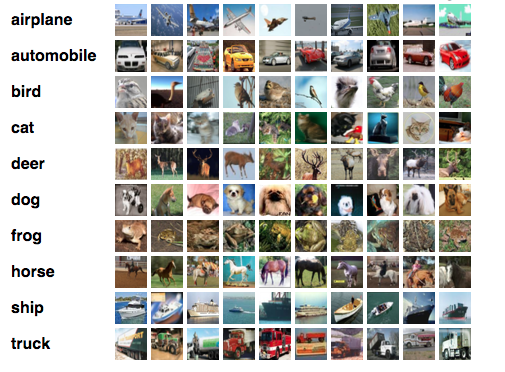

## *Importing the libraries*

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras as ks
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
import urllib

In [2]:
print('the number of datasets is', len(tfds.list_builders()))

the number of datasets is 172


### *Loading the data in as train and test set*

In [3]:
(x_train, y_train), (x_test, y_test) = ks.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [4]:
print(f'x_train dimension: {x_train.shape}\ny_train dimension: {y_train.shape}\nx_test dimension: {x_test.shape}\ny_testdimension: {y_test.shape}')

x_train dimension: (50000, 32, 32, 3)
y_train dimension: (50000, 1)
x_test dimension: (10000, 32, 32, 3)
y_testdimension: (10000, 1)


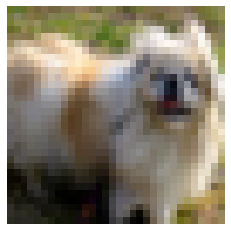

In [5]:
plt.imshow(x_train[40])
plt.axis('off')
plt.show()

## *the above is the representation of each image in the dataset which is a 32*32 image .*


## *lets further split the training data into train and validation where we can keep a small validation set*


In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=0)

### *data augmentation*

In [7]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True 
)

def normalize(data):
  data = data.astype('float32')
  data = data/255.0
  return data

In [8]:
x_train = normalize(x_train)
x_test = normalize(x_test)
x_val = normalize(x_val)

datagen.fit(x_train)
datagen.fit(x_val)
datagen.fit(x_test)

y_train = ks.utils.to_categorical(y_train, 10)
y_val = ks.utils.to_categorical(y_val, 10)
y_test = ks.utils.to_categorical(y_test, 10 )

In [9]:
print(f'x_train dimension: {x_train.shape}\ny_train dimension: {y_train.shape}\nx_val dimension: {x_val.shape}\ny_val dimension: {y_val.shape}')

x_train dimension: (47500, 32, 32, 3)
y_train dimension: (47500, 10)
x_val dimension: (2500, 32, 32, 3)
y_val dimension: (2500, 10)


### *image after normalizing*


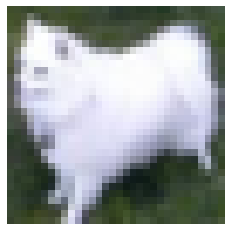

In [10]:
plt.imshow(x_train[16])
plt.axis('off')
plt.show()

## *creating a model trainer and graph plotting function*

In [23]:
def results(model):
  epoch=60
  r = model.fit(x_train, y_train, batch_size=64, epochs=epoch, validation_data=(x_val, y_val), verbose=0)
  acc = model.evaluate(x_test, y_test)
  print('the loss of the model is ', acc[0])
  print('the accuracy of the model is ', acc[1])

  plt.style.use('ggplot')
  num_of_epochs = range(len(r.history['acc']))
  plt.figure(figsize=(6, 5))
  plt.plot(num_of_epochs, r.history['acc'])
  plt.plot(num_of_epochs, r.history['val_acc'])
  plt.title('Classification Accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend(['train', 'val'])
  plt.show()

  plt.figure(figsize=(6, 5))
  plt.plot(num_of_epochs, r.history['loss'])
  plt.plot(num_of_epochs, r.history['val_loss'])
  plt.title('Classification Loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend(['train', 'val'])
  plt.show()

In [12]:
classes = ['airplane','automobile', 'bird', 'cat',
           'deer','dog','frog', 'horse','ship','truck']

## *model predictor*

In [42]:
def predict_class(filename, model):
  img = load_img(filename, target_size=(32, 32))
  image = plt.imread(filename)
  plt.imshow(image)
  plt.axis('off')
  img = img_to_array(img)
  img = img.reshape(1, 32, 32, 3)
  img.astype('float32')
  img = img/255.
  result = model.predict(img)
  dict2 = {}
  for i in range(10):
    dict2[result[0][i]] = classes[i]
  res = result[0]
  res.sort()
  res = res[::-1]
  results = res[:3]
  print('the top predictions are : ')

  for i in range(3):
    print('{} : {}'.format(dict2[results[i]], (results[i]*100).round(2)))
  print('the image given as input is')
  plt.show()

## *the model itself is Heavy along with the dataset it would eat a lot of time,So Lets utilize GPUs*

In [17]:
gpus = tf.config.experimental.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
print(f'running on gpu: {[gpu.name for gpu in gpus]}')

running on gpu: ['/device:GPU:0']


### *The model is packed with 6 Convolutions & BatchNormalization , 5 Dropouts, 3 Pooling , 2 Dense and 1 flatten Layer*

In [24]:
with strategy.scope():
    model = ks.models.Sequential([
                                  ks.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                                                   input_shape=(32, 32, 3), kernel_regularizer=ks.regularizers.l2(1e-4)), 
                                  ks.layers.BatchNormalization(),
                                  ks.layers.Dropout(0.2),
                                  ks.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=ks.regularizers.l2(1e-4)), 
                                  ks.layers.BatchNormalization(),
                                  ks.layers.MaxPooling2D((2 ,2)),
                                  ks.layers.Dropout(0.2), 
                                  ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=ks.regularizers.l2(1e-4)), 
                                  ks.layers.BatchNormalization(),
                                  ks.layers.Dropout(0.2),
                                  ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=ks.regularizers.l2(1e-4)), 
                                  ks.layers.BatchNormalization(),
                                  ks.layers.MaxPooling2D((2 ,2)), 
                                  ks.layers.Dropout(0.2),
                                  ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=ks.regularizers.l2(1e-4)), 
                                  ks.layers.BatchNormalization(),
                                  ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=ks.regularizers.l2(1e-4)), 
                                  ks.layers.BatchNormalization(),
                                  ks.layers.MaxPooling2D((2 ,2)), 
                                  ks.layers.Dropout(0.3),
                                  ks.layers.Flatten(), 
                                  ks.layers.Dense(128, activation='relu'), 
                                  ks.layers.Dense(10, activation='softmax')
    ])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0

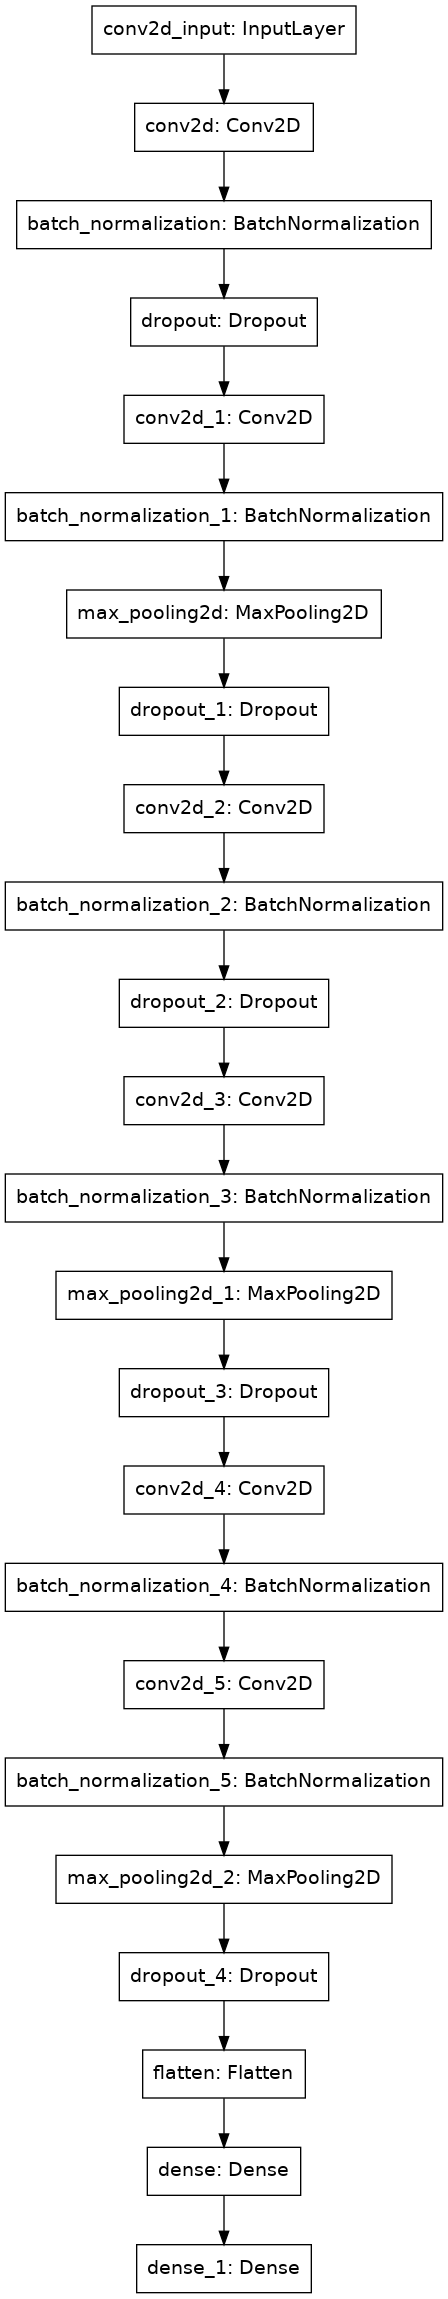

In [20]:
ks.utils.plot_model(model)

In [25]:
opt = ks.optimizers.SGD(lr=0.001, momentum=0.9)
with strategy.scope():
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

313/313 [==============================] - 4s 14ms/step - loss: 0.6308 - acc: 0.8310
the loss of the model is  0.6307796835899353
the accuracy of the model is  0.8309999704360962


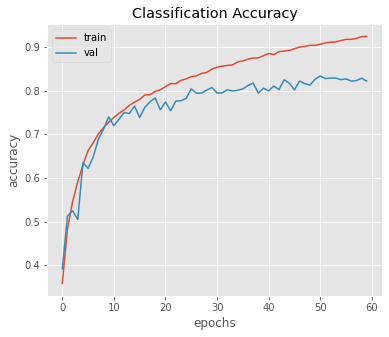

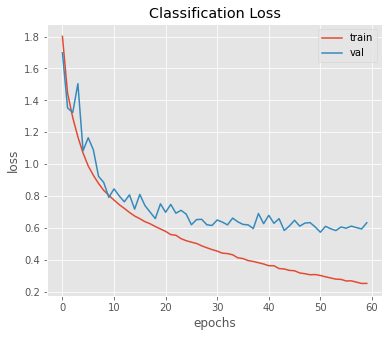

In [26]:
results(model)

## *creating a url image reader function*

In [27]:
def urler(url):
  resource = urllib.request.urlopen(url)
  output = open('file.jpg', 'wb')
  output.write(resource.read())
  output.close()
  predict_class('file.jpg', model)


## *lets see how well the model predicts*
## *we'll get some images from google and see what this brainy guy thinks*

the top predictions are : 
dog : 86.76
horse : 10.4
bird : 1.92
the image given as input is


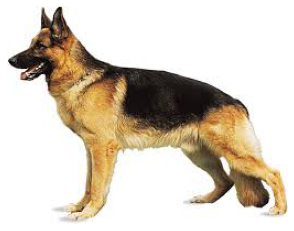

the top predictions are : 
automobile : 98.7
truck : 1.25
frog : 0.02
the image given as input is


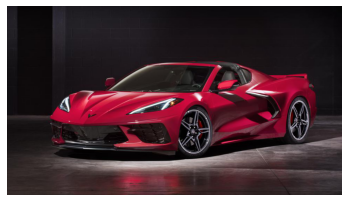

the top predictions are : 
ship : 100.0
airplane : 0.0
truck : 0.0
the image given as input is


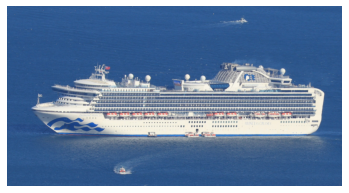

the top predictions are : 
airplane : 63.36
bird : 36.55
ship : 0.07
the image given as input is


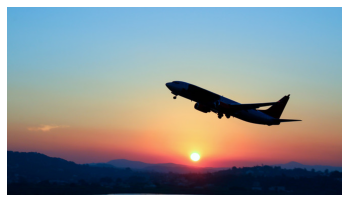

the top predictions are : 
bird : 99.99
cat : 0.01
airplane : 0.0
the image given as input is


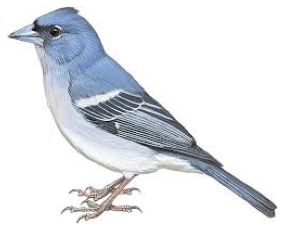

the top predictions are : 
truck : 100.0
automobile : 0.0
bird : 0.0
the image given as input is


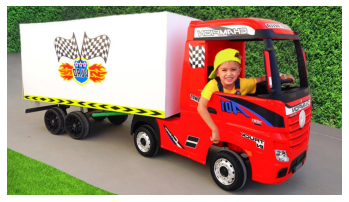

the top predictions are : 
bird : 52.5
airplane : 47.47
deer : 0.03
the image given as input is


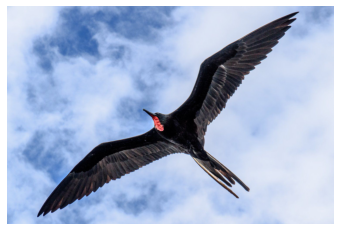

the top predictions are : 
deer : 71.49
dog : 14.11
frog : 8.64
the image given as input is


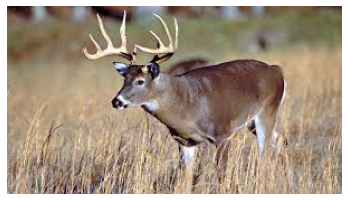

the top predictions are : 
frog : 100.0
ship : 0.0
cat : 0.0
the image given as input is


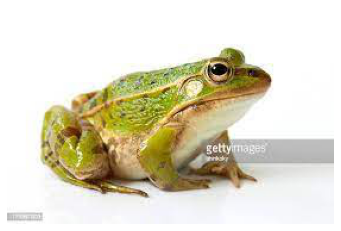

the top predictions are : 
cat : 89.89
frog : 9.88
dog : 0.18
the image given as input is


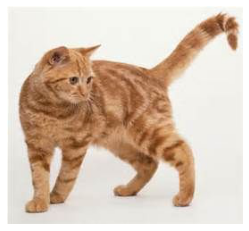

the top predictions are : 
horse : 99.88
dog : 0.12
deer : 0.0
the image given as input is


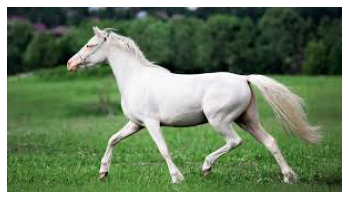

In [60]:
urler('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSfx__RoRYzLDgXDiJxYGxLihJC4zoqV3V0xg&usqp=CAU')
urler('https://specials-images.forbesimg.com/imageserve/5d3703e2f1176b00089761a6/960x0.jpg?cropX1=836&cropX2=5396&cropY1=799&cropY2=3364')
urler('https://upload.wikimedia.org/wikipedia/commons/2/22/Diamond_Princess_%28ship%2C_2004%29_-_cropped.jpg')
urler('https://ei.marketwatch.com/Multimedia/2019/02/25/Photos/ZQ/MW-HE536_airpla_20190225131547_ZQ.jpg?uuid=5fa81d1a-3929-11e9-9462-ac162d7bc1f7')
urler('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQQVOIuBGDf8veVweb3mi4ERm3L901nc7aOLQ&usqp=CAU')
urler('https://i.ytimg.com/vi/DEsQs2jLEOg/maxresdefault.jpg')
urler('https://www.thespruce.com/thmb/rAZ8XEnb7W-Wz8btOecZORirQSw=/1500x1000/filters:fill(auto,1)/frigatebird-5b045e571d640400376297a4.jpg')
urler('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTdFpNmqplFiar883jTdIokOwAkIQ-MJ9Fldw&usqp=CAU')
urler('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTlnvjI9MkNkAP5Vp5OJ1avDUbHa6aoNSw4El_a-BCSkGBgth6X9rCdu5dTU8wz8nTPM94&usqp=CAU')
urler('https://i.pinimg.com/originals/f0/9c/dc/f09cdc5790c3fd40afab6f93c98a5135.jpg')
urler('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQCfVm9gDiMcQnbMDMdc_uUy7VWI4YhsEroig&usqp=CAU')

## *The model has performed good but not great.It just sucks for some tricky images show below. As I trained the model only upto 84% validation accuracy.further fine tuning the model would surely get it a great performance. Instead of training a sequential model , we would train a resnet for more expectation, but playing with a child gives more fun than a giant.*

the top predictions are : 
horse : 43.98
deer : 38.66
dog : 12.29
the image given as input is


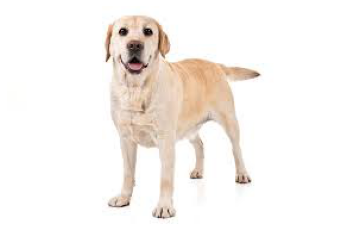

the top predictions are : 
horse : 55.16
truck : 38.05
frog : 4.33
the image given as input is


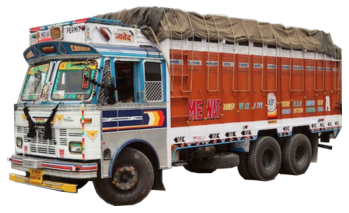

the top predictions are : 
frog : 76.03
cat : 22.44
dog : 0.93
the image given as input is


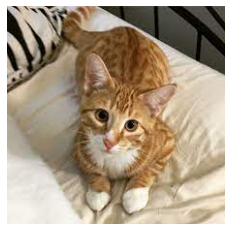

In [62]:
urler('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISERUSExMWFRIXFxgWGBUVGBcVFxcXFhUYGBUYFRUZHSggGholGxcVITMhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGy0lHR0tLSstLS0tLS0tLS4tLS0tLS0tLS01LS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAbAAEAAgMBAQAAAAAAAAAAAAAABAUCAwYBB//EADsQAAIBAgMFBwMBBgUFAAAAAAABAgMRBBIhBTFBUXEGImGBkaGxEzLw0RQjQlLB4QczYoKSJHKDovH/xAAYAQEAAwEAAAAAAAAAAAAAAAAAAQIDBP/EACMRAQACAgICAgIDAAAAAAAAAAABAgMRITEyQRJRImETQoH/2gAMAwEAAhEDEQA/APuIAAAAAAAAAAAAADyUklduy8SJLF3vk3J2v032ImYhMRMph42Uleu3LLdX9yHGH7x3d1b3vYynN+msYd+3UXBymIxDpytGWvJXv5EnCbecGlW+16KXJ+PgTGWPaJxT6dEDxO+q3HpqyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFB2x2gqNHV2u7+S/u0QO0e13gsBOtCGepGEcsNdZSaSvbgm7t8kyJ2+tVrYeg/sdSmpLnnqJNeh0lajGpFxaTUla3C3KxzczeZdPEUrH+vk3Ybthi8VjnQq2qRv96h9NxSTvmipStr48r8j6Y6CjK93ZdeZBq4XDYKLnGEaba1cUk34FFW7a09YuE0+d4ta81cTrfS1YnTme3va3EYPaGWnkUZKNnOGdWdlJpOUVe1+O9W03nTbB2v+37PdaUclS01KPKcNbrw3O/ibpYGhjbTnFSy6arVX1tqT8Xh4UcPUikoxjTnotFZxImYmOiI1Paw7C7YjWw8It2na6XOPh479DqD412bqShQwtRNpqpCflaN0/8AlL3PsVGopRUluaTXRq6L4L7jX0zz01O/tmADdgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADju0lNLaOEk90pN+cac0l6uJfwmracHYpdv7Fnito4Z6xo0IqrKWqzSzvLCL53im/DqjTtWdSpRqUoPJL6koX101tB89dDDqZdHcRCt/xNoOeHzRlZwu7KyvpZ7/AAfifD5RvanFTSTTXeV9G33nZJq73WXkfbO1e2aMsB9WTtGcE8v8Sdu9Fp7mpaPofEcNtyLq2cLUt0bXzJ3+59bl4hWZl9n/AMO8PKOGeZ3u014KySRa9rJr9mnTX31IygvSzfuQ+yeKg8Nmg81o6Jc0tPclPCyf0lKWb6au298pNaGdl69qLZdPLTjTcXnptQy21clJ6JeR9RwFJwpQi9GopPrbX3uU+EwdOniZV75XOKUk1dZu6lOL4Oys+viXjrwWuaPqhhrFd8ozXm2o02Aq8VtylDdeT8NPdkV9pFwpt+GZX+DSc1I9s4xXn0vgUtDtFTlo4yi/Jllh8bTn9sl03MmuStupRbHavcJAALqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUUaCVSpybb/AD2Lxspqt89+ZS/pejg+2uDdOq8RCKlTyt1aSv8Ac9JNJaWlFu76vVnIS2ls2S+xp8vpO/S67vufUJx/6iUpaxcVFRe7Rye4hx2Hhs3+VB2eZXV1foZxb7dVbzXpQdmth1HKOI+q4UW86w8YrL3bKnnk1fSylZaNpPwOzox1tvdyNjcTGko04/c+HJEjCu3W3uZzbnSO+U+q0/FfiIDo2vHXT7ZccvK/GxLUjyLv5FbxuSk6Qmr77Zua4/3Is5W3pfnIk4mFp25/nsKtC6vx4/1OeYdESg05Xdra/JvjdNcOnM0ODi78vj8+STe/lqVhaUn9qnG04Nq29X062JE+0NS11GL57yJhmr+HtrvJK2Yox7qumr8zopN9cS57xTfMGH7UT/ipx8nl/UnUe0tF/deHXVeqKl7KqPdB6/m801eylaotXGHPM2/ZXNqzkZWrjl2OHxEKkc0JKUXxTujac92Z7LRwcpTVWc5S0a0jC3hBcfF6nQnRXeuXPaI3wAAlAAAAAAAAADw9IAAEgAAAAAAADXiH3WVUo5l+haYn7JdGUWFr97Lp6/JndpRp2hhE8tnqmr31ut2/zI1PBT+o3m05JdPfiWeJorLL+Z6fp0RonKML+b9LJGNv22rKtjgZTqOpLhdLlZciRB308f6/oK1dKDt4XXHUywce6m1w+dSscztM9JFP8+DOELXZrgzbfeWmEQi4yN3FhPQ2YtpWv4mjPoc9u21emmrTTT6GFNXNkdUzKEUimuV98PNzLzYWIunDlqvPf7/JTWJGzKmWtHxeV+Z0Y51aGGSN1dOADtcYAAAAAAAAAAAAA8B6AAAAAAAAAAAAwr/bLo/g53L3r/B0dSN01zTRz+Fe9dfUpdpQxlWNn3l5u1iGm2uEteBJrQTVrJkOjgYyV3HerWd/UwtG21Z0pcPKrPEVqbi0sya4d3g/Q6JZVaKe7luImD2bCjfLfvb9dPLkSkklZLXfz8NSKlmyVraCizF6oyokyQ14uXeIdSe9G6q23cwjS5nPbmW1eIeYZXNtWlxMXUjTWv5xNOzsfGpezWvDzfLwsaUx7jlS9+Uum9DKOkovlJP0ZFxN4u69CTFpq/EtHelZ626sGvD1M0YtcUjYdjkAAAAAAAAAAAAAAAAAAAAAAAAAAAKXaNFwm5LdJX81a/6l0RsfSvB+Gv6+xW0bhas6lzjzN71ru6+JHwuInHuztLLpxRsrKTdrWXB9DVi6bvJ6X3+285pjTpidtlbEvfkdutn8GdBJq8U9G7pu+/e7lZhHNN66eOpZqGsXFWUtG+WjeoiETOm3LqZrS/Q10o2vr6f/AE2tXi10+Se0NKaeppq1HZ23+xIp0XLRLRbzfKjGMcz4cBFPsmzXs3Ykavfq3kuT0TfTlvRf/slO2XJFR5JJIw2ZWU6cWujtwf58ko6KxGmFpnai2tsyyco7uXIqMNN5eh2c4ppp7nocniKH0qjg9z1T5oyyU521x39L3YlS9Po/nX9SwKjs99s+qLc1pP4sr9gALKgAAAAAAAAAAAAAAAAAAAAAAABhXV4yXg/gzAHI1n3muDNWCpTq1fp5raNp77eHRm/accs/9zXzYz7Na4ib5Qfyjn1uXRvUNGI2TVh/Dx3rU2YDDVoKWaEsr114M6w8aNP4+Wf8jnZPTzN2zqOadnutc01NPI37Il+88mUjyXnxXUKaW5JFDt3AW76bs3quTOgIu1I3oz6X9NTW0cMqzy5/svWarSp30cdVzaejXjZtPouR1RyOwGv2leKa9r/0OuIx9JydhT9pKCcIz4xdvJ/iLgr9u0nKhK29d703+1ybdIr209n2sslxun5Fsc92eq3kvFP89joSKdF+wAF1QAAAAAAAAAAAAAAAAAAAAAAAAAAcz2ij3pPk0/RI87JxvUqy5JL1d/6Gzb9RZ2n4fBn2RhaNR+KXon+pjHk2nxdAADZiosekpy6/Kue7F1qPwRhtDWcupv2Iu9LwRj/ZtPiuCNtKdqU3/pa9dCScj2l2w1UlSussE5Nb3J2va3Sz/wB3gXvbUKUruUjs9D975M6Y5LsZi41WpqUW8ibUXdJta25q/E60jH0nJ5BjUhdNPc016mQNGbjNjTcJa8Jf2Z2SZwVXHRp1Jtyjb6lr33ObWVf+0fU7DZWKU42um46O3sZY59Ncke04AGrIAAAAAAAAAAAAAAAAAAAAAAAAANdasorVgc5tt3qyfReiN3ZG9qt9zkmtNOPH89yJtCtBpyb6l7sKllw9PxWb/l3l7NGNI/Lba8/jpPABsxcntGu/qzt/Myz7Pyu5voQ6tJOc3/qb9yfsKlbO+iOekT8nReY+K2K3HbFw9Wf1KlClOf8ANKEZS9WuhZBnQ50HAYGlS0p04Qv/ACRUfhE40wWpuIhMgAJQ+YY/sjjbzSdGrGdTO3KU6b7uXIsuWWvcjrfhuOn7PbIxFPESrVJxSlTUZUoXks8b2nnaT+2ytb+FHRZNTakUikQvOSZjT0AF1AAAAAAAAAAAAAAAAAAAAAAAAEDbO0FQp5m7JtRzPcm913w5HPvFt1WnJKKindu7k5N2svBJ/wDJHWVKakrSSa5PVehAqbBwst+HpP8A8cdeumpS1dr1tEOEr7bozrwoU5KpUlVhCSptScc0rNytpFLe7n0uKsrcCNhNnUaSy0qcKcVuUIxgvSKJYrT4l7/IMK1TLFt8DModrbR/fKinaycpf9tlq31kvRlpnUK1jcsrr1Juym++uF1bzRxmExdapRxE4/5iqVo0M269NZIprl9SMvU6DYW0VOcYxe+KbT3rTjyad1YyrPLW0cOiPGeg2YtcYmwAAAAPEj0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHiAA9IG09kUcRGUakL5o5W03GWV8M0WnY9AFdhOyeHpO8PqJfy/Um1dycm9Xe7cnrcssBsujRu6dOMG9W0tW3q7y3sAjUJmZlNDAJQIAAAAAAAAAAAAAAAAAAAAB//2Q==')
urler('https://5.imimg.com/data5/MW/JN/FM/SELLER-89031277/10-chakka-for-sale-in-indore-500x500.png')
urler('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFhYYGRgaHBwcGhwcHBoZHBkYHBoaGhwaHBocIS4lHB4rIRgYJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHhISHjQrJCs0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAOEA4QMBIgACEQEDEQH/xAAcAAACAwEBAQEAAAAAAAAAAAAEBQIDBgABBwj/xAA9EAACAQIEAwUGBAYBBAMBAAABAgADEQQSITEFQVEGImFxgRMykaGx0UJSwfAHFBVicuEjM4Ky8ZKiwlP/xAAYAQADAQEAAAAAAAAAAAAAAAAAAQIDBP/EACARAQEAAgIDAQEBAQAAAAAAAAABAhEhMQMSQVFhEyL/2gAMAwEAAhEDEQA/ADuBcTo8Qw+WoqsQAHRtbH8w5jqCIXwjh74R8iOz4Zj3QxzNSb8tzuh+InxjhHE3w1RalM2I3HJl5qfCfd+BcSTE0Uqpsw1HQ8wZnleF4vX4flq+1RspYWqL+FxybwcdeexiyvicZSrZXIqYZ9A6IBUpHkXUaFf7gPO0f0qoYlea7jp0PlLGSTiqvnvFeO4vB11TFZK2FqG2bIBoeR5XG9je4heL7N4NCcUtJ3Q2IRO8gPUKNgfDQTU8T4fTr02pVVDIwsR0PIg8iORmR4TRrUPbYMubhSaTMLggeH1AlVMM07QGgFd0yUWGgC3IPLUbHzGvWA4HteHxSoQSrhiDsQB9RrFHBsNWxOHxFCqWWtSYvTYaja4H9yn96zsBxdquFVKyIHU6MFAOnXo3iLRZZesGM3Wyqdo6RJTPY8idv9GZ3HviaTh890O3QjyiIYHOTkbMw1tzM03Z5jUpvTfWw0vymGXkuXbpxxmPMWvrlqJ+LRh4w7DUSylXVWVtwwuD8ZVw3DkLkI56TQYXDc4/Fjbdo8mU6YPjHYgNd8OxQ75GJK/9rbr639JjMVhalJslRWRuh5+IOxHlPvmQdIFxDhVKsmSoisPEbeIO4M6Li535/wCKE5QbnQxlRckA3Owmp7Ufw9cKxwxzjfIxsw8FbY+tpkqKMgCOpVl0KsLEEdQYtaAxXPWWq/jBFMsVoASz6HyMU9nHPf1O4/WMQ0Vdnz3qg8f1MZHlRQwKtqDymf4jwtkuyEsnTUlfuJoAZ6DAMbRxDoQysQfP93mj4dxYP3W7r9OR8vtB+JcJDXZNG5ryby6GISCpsbgj0IMZtxn8YNjsMKilSbH8J6GK+G8XvZHPk33+8dAxBm8Di2oOVa9tmH0YTTK9wCDcHUHqIt4vgPaLmX312/uHSAcG4hlORtidL/hPTyhQ0WYzpC86I2Mn0P8AhVxYK74djbN3k8+Y/fWA9rewzUA1Whd6Q1ZTqyDr/cvzmU4VizSqpUU2KsD6c/lCwTh9249h3CivR0q09cvKom7U28+R5GHcH4imIpLUTY7jmrDRlPQgyzBVw6K/JgD8ZgMbjzwzHMTf+WxHeI5K/Nh+siLrf1W1iLtPgmZQ6D/kXv0z1dRqh8GW4jTBVg9mBBUi4I1BB2IMvxiZk9QR4ESqUZPsxi0ctUQWzKQRzUjdT4g3mRxCFncDUZjfwuZqsS6YavWYDKlVSwI90Vbajwzb+YMxPBuIMb5rE3O++8yzm4vC6o9KJQhr2YagibHs9iEqXYWD2sw2N+sySHOdYQwKe4SD1G4mMbXp9CprrD0fYT5wnG8Qgsr5v8gCR6y2h2mxN9GW/Puib4+SRjlha+ks1pRi8clNczuB6z59W7RYh9GqAeQAiniFRnOZnLeZ5yr5p8KeL9buv2vw4OmZuthFXEeMcPxJyVVYMNmtYjxDDUeUxefX3TrI48EFW9D5TP8A2q/8oaY/sw4BfDuK9P8AttnHmBv6fCINtDoY04PxBqL3ViM3wPUEc5ramHw2NHfAp1uTLpm/Q+Rl4+SZcXhGXis5jAq0V8FNnqDx/UzVcZ7N1sPckZ0/Oo2/yG4+kyXCz/y1PX/yM1ZHgaTzQcNJB4EvzQLiHD1qC+z8j+h6wgNJBoGyVakyMVYWI/dx1EY8M4oUsrm68jzX/Ut7Q2yoedyPS0UVKbLbMLXFx4g9IybNXB1Gt9ok41gN6ij/ADH/AOoLw3iRTunVf/Hy+00SVAwuNQfmIjZL+ab8zfGdNH/TaX5BPYuA+zYHEpXpq6EMjj5HkZ8q/iD2UGHf29Jf+Jz3lH4GPP8AxMv/AIYcfKOcM57rap4HmJ9O4lhUrUnRhcOCJNtlXrcZT+GPGPa0DSc9+nt4pyhXb3h4xFBlt3l7yHxH3nz/ALM4psDj8j7ZsjeRPdM+ncacGwHOF7E6Y7+F3HSGbCuerJflb3lmz7T8YFCiz723Hh4T4/WV8Njhc2KuDfwYzY9tcWalBgDvYwyGPQniuNR6IykPnAYDnbe4vzEyr8La7OmlpRw2kyoinU308B4Td8OwoWmFIuWmdXGWwGKIsrKQfKGsxvHfFODK6jL3WXYxI1HIbPuJFi5UD5TkpljlXTqZWxdz0EISqFXuG55mTaqRRjcLlBynzgtJzkFxfWWPUIu7a32njPmW1rX09IjeDEpfNzAlPEDdLjmZY9AL5CUuocadYlRSDb0sY+wgvZtevgYgqNYhPQxvQxjKAANbRVUjV4XjLJYEZkOpG9hztK+I9jcPXvXwxCMw1sO4x37ycj4j5xThbuA4Nip7w/tJ733ml4VXFM5k1U+8vXxHjK8fmsusumXk8Us3O3zziXC6tBrVEI6MNVbyb9mB3n3CrhkqpqFZGGx1BB6gzEcb7EDV8ObH8je7/wBrcvIztcumHDSYadicO9NijqUYcj+nUSoNERdx99EHn+kY1MMrIEbkBY8wbbiKeM6sg/epEdKYwzOJwzU2yt6HkRCeHY8obHVDuOniI6xFFXXKw+4PUTO4rDNTax25HkR94dhof6jT/OPnOmYzCew0DnimHbCYthtkfMvipP8A7n2LgvFRURTe9wDMT/E7hxISuBt3WPgf2Id2ExLPhwQLlNDIvM2ucXRN/E7ABaqVh+MWb/Iaj9Yz7H8WfEKoe5NPQtyIG097dYtHoFXuNe7/AJCCdnOIKMIqooDbEjrDfA+he0VBK2OvcWVQT425SHEsQzsEGijfyEENFvakIC9Rz71tFWarB9mbge1fzVdPiZF5OA+z+F9o9wO6s1qoE15/Se4eilNAqAACD1X1ivCl9TEWUseUxWJrlmLHYmaLiVQ+za3SZVkN/CRkvE5wKggEi99hD34Yj8gptbMotryzAbiAYZLBelrzRYBsy2sDHMdxXTDcTpFXIcWKaW6nw+UprVybBflNZ2o4fnTPbv07A+KE6E/4n6zIq5Fsoub/ADkU1lVTk724H/oSFBAoufP5SePBC67854D3AT+XX1kqgBVzPr1jfDAKtzy2ilAS1xGdc3so23MWS8TfDuF1G7C46MOY+EYU0yHMvuHUeHURZh1KotxcKQfITR8Ppq6ZfE6dOvpz9ZlVb0ccFqn3dLNqCeXURu1jpv8ASZvAHKcrfhNx4jSPlxWlkU/Cdfhz3jquTzY6yCcU4LTrLldAR47jyO4mB412IqJdqPfX8p98eXJp9KXOeXxlmQ8yJvvbDT84cTRhXVWBBGW4IsR3uhjYGfZOMdmaOJH/ACICw919mXyYa+kwvFexFVLmk3tAOR0b7GPY0y4MhXoq6lWGn0PUSVWmyEqylWG4IsRPAYEV/wBF/v8AlOjW86PYfVuIU0ro1PLmVxY9NeYiXB8Hw/D0BGdmdrddeVxtCO0mIq0aKrhbZ7ga20F/H1iLjHHldUSpZnWxsh1DeLbTPemgztdgUq0SpIV9wehmc4NwpmtSpE2/E/IeUb4LhNfEtc91OZa+36zW4fCpQQIg8zzJk74PQLA8OSgtlHe5nmTCg0gxJM9Ak72aLtBao1hTrA6oteXMU7AY9+4dZn6lQhdOcb4hSQ0UZCSJOcXiaCplABNu6LH0jfg1QubBh4jUGKsfTuik2DWGnWwnvBkLHu3a3IK/ya4tFi1y6avGLltcaEEMDrmUixG0wuPvRqslhYEZT1U6qfUGa7EcQVUKm9/E5v35xbVRK9MMyi6C1+YW+mo6E/OZ53VPGbhDxBlKX9PWUml/xgdRe/x/1LMXRKggchf06iV5iUtz6/pJVI7h9IW1/ZhmBRXewG3zN9B++kGpnIltCecO4UhAL215SMlQfVVhb8p0J89oXhkYIHXQg2PmD+ogR4iWNiNOcae1VNOT79CCLX8+czUYUkuyPyYfv9+Ee4d7aGJKSH2QA0I5+RsY2wyKFXPa52uZ0eHph5Rori9hqZyG2pnosNhKCWY6C06NsBD1b7m0iljsCZ1OkF1OplntekcqSrinAKdcd+mCeR2YeR3EwXGuxNRCWonOv5Se8P0M+oE3nZB0j2Vj4f8A0mv/APyqf/Ezp9t9kOk6PZafJU9pXb2dHM9/ec3J9D+ETU8C7HU6VnqAM/xA+8d8Ow9OmgRFCgdPqYaX0mW2qjEEKLKLeUW1IViXgTG8XY2rlqJPVSTtLxxRaqdIFiQBqYdUfpFuJw7NvtL3OoWv0qxFbMcqwFLBtdgYbiQEOikkQILna23P0keRpiO7TFLgob7f+oNw7iNQDIi5b7WAF+tj1+cX4ik5fve7+9Iyps1gNgNvQTL2011tXXFZ+819ut7j9YRgMWEVkI0KsPiP9ysK+/1nlRFW5Pn6WJ2meV9lY8JrkUKHN2yMW11KaZdud7D1nPSvZjYAaEabXy6fOeYbD5AKlQXapfU7Kq62t8PWRw9MsVS/dCEv1sDe1+uUf/aZtIpqAIdU3sVHUdT4Q2ni6YGpA8rwcs1ZA+gZyQeiqDYAeFgIXX4PSRVOrsepsvoBy845yOVCY2m7d1WJ2sov6nlG2HoO6BCMtjdSdSB5D7y3huAGmg02A0HwEaqFTfbrLx8c+pud6UrhbLZmZh4mw+C2lFHCo1QZbqwsQQTa19QRe1oViXNvDl4y7g+AK99zqdh+s01Ooi3jdOaTEG3KXswG0GB9BPS3SXGNTLSaiVj5yy8qJSBntp4okwIyRtPZbknkAylOvLf5mK2e0uonTWZyLtEsxM9AlOaePU5DeaTUm0XlezgSGp8pWi8zLgYdl09taU1RcS0tK2lwFeJo6G0UKmRjm3mjrsBvMnxmuwNwLk7SPLf+VYdrXUltvtGGGpZh3bX+MVYChiKg95V8CJTxHEV6JyK5Fhmc2sB5eM5fXbfemjXBMHUcjuDteQ41hw1ZaSDcAac9N/gTMxwftvVDf8n/ACJzJtnA/MLdJvMHUQuao96oNPK19o8sLiczmTO4pyQ6tY5HKINLABRc+OpHzlnDaaq4d27zIzqL7JYd5vC20v4twzbLe7Elj1vvbxtL0wIp0HrMvfdgoH5UvZV8rATKtYGwFDNT091iSLjYX0llVbCwBNuUbUqCpTTMbMdh9NJ4+Hsbi/hFLqmr4LigSFsQRsOvh8/l5wrHVGIIRb668rHqPt4xTjqBVldWy3+ojnCU2VC7m4K2Ou55WE6Zlwz19e8JwJZhn23y/fwmgZLCVcJwmRMze82p+0rxOIuSBHOmOV3Xue5nrN0lJaw8Zdhl0zn0+8cSuUW8+f2k7ASpD03lqjrKJOmCZeiSNNYQglJRyTpZOgGCxFMHXnBhU1tGNRIuqpY3iv6cSz9JOn1g6vLR4xT9ov8ABIaSDQdWk1a0raV15FmkQ0HxFYLH7DSGIYWJYxHWcOTqFAGl5fiajOddByEU4lhmyHy8pGd4aYzkXhsaaNQHcaXh/aXh/tkaqi5kdLOF1ZTuGtz56RN/T3sbMDbkd/8AcY8B409EkWJHS2hmDWPnowJQmxJJ0AAYXvyP2n1LDUigoIfeCi/wAiXjmOSo6lUVLsL2GpN9Zo+FIXf2hHdGgmmWftOUTHXTQrhb5B4a+ZMF7R43DYamoxL63DBACTptoOUb8LABZ3NgupvsJ8k7c0q2Jeo6qxb2hIXmaQACZRzA59D5yMMcb2rK5Tr41vDu0GGxLgByh2XOuUHwB6x9iMIEsB58p827K8MdjTp1EBbMGt+IKDcZyPgPQcpvsZWai4puDkOlN9SP8T0Mz8mOMvDTC2zkvx3D87AXtlJ05HnaRONZXCPqi6DoOvr4xw2JWzbEgXHiZm6dNWDl21vzMz9quRrsdxDNkVDcWF5e9EABjt9TMrw+oabZhZk053sI9XFZwBuJ0Y5ezDLHS5AXcAc/kOcJr1RmCL+HSCUawRS53Og/fnLMDT7pdt2N5pGdEscohFIZheAoC5ty6w2jUC2B9JUKjKQ0loldIEybtKS686QvOgGQaUVkuIWVlbiMim+U7TjUvL8TT8IJJvCpyvV56KkGzTwmSel74jpKHW8gTI5pUidqcViQik3mdqVeZUXJ3FwftGHESW0EX4imikZ2O34R+sjJeLV8ERXA3uvUa28xLG4MxJ2A5HrA+zKgWKhivVm39LC00ztrtcfvaVjjL2LlZeGaTgGVxnIy87b3O03KU1p0AiAAD47b+JmQ445DobsqtYXHJr6X87wvDcXYqUbU9evjIzsks028eFykyQ4txVirU1a2YqGtuVBv9o0xIwj00WquZgo1Fwb26iDcO4Abs9S4ze6DobdReHtwsVAQCLrs1/3pOae0rTK4hcHjKGH/AOjRIJvc7n5mS42HrUO8Ml7MF56a3PSJcXTZNabgsDYgi+3QHaFYnibtTAcWfYkaX6Dyjt/RrncC4EvlVTYm51vrIPTDDbz8Z7g613ufHbWFqgyA6ak9OchYbDYdKbi5srDqRGNCsEPdOa+x5C8rw2B9q7Zr5UAA8T+/rDsXg0ARFsDf11Fo8d7RnrSeApF3sdh9TGnEjlAVdzpBqDBFW29tfMEiX0nzMGbkPmZ1TpzUbQQInei9KhdweX0Enia99LyQsi+JlJOs/dAEqRrbyGCJKAmC4msS3hK2kwzrOgH8xOhsyipTsZS63juphr8oI+D6S9JKHSKsRTIM0bYU9INWwN+UVhbZ/PPC0Ix+FKG/KBZr7SdL2kWlVapYeM5mtAcQ5j2WgmKqEmwka6AZSRfT0HmftIYlSAbc/wB/CX0WzpbTTbzmWXbXHo54NiGOgFl+f+hNGpuNDMFgHZWCliBf4+n3m24fVBFhyl43acsdBuIvdGVkJPI9CNjGXZOgigO/fcbXHu7cuvjCCFUi/OFIFOyAdY9c7OZ2Y+sNMXVDkDukdCp+sGxFJ7BaQRR+I20PhaSorYw2mwF4em7uo9vhNisEEQuy5yOQ7t/Pl8pkuJKtRs9sttApt8jsZq+N8RNIWtmRufNb7g+X08pjTd37veUnpbXxHI+M5vLqXUdHi3rdXYPCkKzDnoN/XSGOwRCg3O86vUVVAXZeW/e8LxatRjfQlm5cx5zHTbZnU4gEWwPpfnLcIjuPaMP8fvB8BgVHfrG+lwv6eMZ8OxoYkNpr8OglYY87TnlJNQUOvI6jwvvf1liydallHh06yBFkv128BOmOVLDpdtddrek8xjFnA5CTwPM8gPjI1KwsVXfr0jBlRe6ZV5c5S6KDqYvoYzICsHq1ySTeP2Gjb2ifsTyJPaHxnkNjTZOglbIJImRAvN2Sh6YlDUoc1p5kvAE2NwmcWKgzLY3BFDtpN+1KLuIYS4OmsWWOzl0+f1UtByltTvNIeHZiS/y29IvxmAF+7M4qs5ih0g+HqW567x1XwDRJjcOyNtYwym4eN0ZgB1LNo3IDfw0EZ8KxLo9m2AsAP1+Qmcw+LI5eXUmH0OMFDZkNvDU+cy5jXitXiMeC6+C3J89Iwo4oWv1mYqVEZM4OpGxk8FjbqBflKmVRcW3p1xlvfa0BxnFsilgdr3HgPtpM+3FrLa9jFLV8xbM+hN/Q3B+seWV1wWOM3yZYnEtVYgag8hsRyFuu8vpZaK9W5HbToYup8QUWCC/Inxtv4Wnr1S4171jsfnObL+urHniCTc94AkcueviORkKeBD99XKPzudD68pdTqFEVkv5bjyhWHVK4PcKtzkzniHbrl5wzDMykscwAIH3kWGV44wdDIuXzinEOGf8Aes1mOowuW60eFfMAL7zsVS6mw6SHBkAUseUF4rjwx8Jp8Z/UqmJshUfi+kDD22gj4q8jTR30AMQF1cQo85CkrubKp84dw/gh3fWaXB4FUGglTEWs3/R3/NPJsfZieSvUth/ZzwjpL1pz0oJszDlZNRJXE530gSAEi9MGehDPfZwNmuM0MhvyitKLOdB68pssZhgy2IvEGJYg5FFrbzPKaqsaXNSVdPebnEXG8JoCRqZraeFC6nU7+sXcUoh1PM/SLamCVcu5jPBUgQDYgeMto4ItntytJMcg715lnK0wsSrUg4IAmdetVpuUHI6eR2mowv5gO6fCLsRSV8QzDYW08bScLelZyFlZahO+8HGEdqgUMbC2Y+HT1tNN/Li5PT69JDhnDncHIpLMbnoFvYXMus5FFFMtlBAHlGtBStiBccyu/qDoY44X2OdrFnA66Xjmj2NVWDCow6gWsfjMsvHll8bTyYydgMLTARmAA0uOWsXYTMHYnS5+N4x7QJlf2aHRbFvEnYRfh8Ix1JMMcLOE3LfJsmITe/KJMS6l+7DHoW0Il2FwCKpe5PM33A6Dzmmts9glxr2yLe55S7DcNc6tNNgeFKgzEd9hr/aOgljUyvKVMS2SpwRTqfhHGFwagWAlyrfQbwmhTtKkK1ZQpAQgJIlgJVUxAHOPiJ5oiwnRb/Ul6ieQ9oPWjAZ4VluWe5ZqlRYStjCSsqZYEhm5SxBIqsmIB6wEU8RwuuaOQJXVpgjaFmzl0yeLfZU3POCY+lkTxI3jmrRVH2gXFhnWw3mNaQp4UAaY9b+JvHOB4er6Oob6RDw5GpNkcd1tVP6TacNcbjpHwmpNgENPKVFrbWnzHF4YJiGCG/Twn0LtLxZcOgG71LhFGpJ8ukx+G4YyIatQlnY3Pn0HgJN0rHegldcqAfmIHxmx4VkRAqjkNuZmE4njGuLqAoI87Xm14RXXS2xAt8I8Rk0mCe2kOBOsGwi84RXqqilm2A/YHjLk0islxmmPbuTrcr/4jT6zygD03nvs2Zi77sST5nkPLaMKagCZRoGbBZ1+kXtQZXsNh3j/ANuw+P0jpcUgvcjT6xdiMYpYkCF0IbcNxl9DC69ZBuRMsMQ/4NPKW0sFUc3a/rHstHD8QprtrK/6qx0VJHD8MtvaGoiLzhyARas/hPRw9m954xUCVV66LvFwYX+lp+c/KdPf6is6LcGqd3nXkVE9tOlkkJBhJEytngSJnJPLTlaAWAydpBRLFEAXY/C3FwNYho3L5WmuYdYsrcPBqB/iOsjLH6rGhcXwlatMqdDuCNweomZ4TjMRTqvTcqwQG1+djoZvK7BVvMbhqBeu56/szO8Ljzh3DTWqtXqHM2wPJV/Ko5CG8dAsqi2nKG46sKKBV3PymbrVSbkybfh/0tOEznLzMu4Vjv5Z/Z1tFU6Na+nSSoNY38Y1TAmqbsL31lSlR9HtCXANNO7yLaX9JFBWqMWZiTy6KOVh+sYYThaqNYaXAGg0jvPZFRwTc2Mj7DXYnQ/p/uHPUvKziRtzi0YP+VX8stTDoPwCGrI1IBBFtYKg1nuMxJQWBueZ5DynqVdILjGW2pgYSrinb8Rkf5p1Fy1pQa4Hui5kqHD6lU3NwJOgJoYx30FzDE4czasYZgcGtMWGphySpj+i0q/pKdTOjnKs6P1hbcslOnTVm8aVvOnRkidpGnOnQC4SxZ06AeGVPOnQvQgXi3/T+ES8H/6jeU6dML21nSPaH3h5RBX931nTpF7P4hQ3E2XDfdHlOnS4VGPBOU6dHSio7GB8/WdOiMxSSr7TydAgTc4rxW86dEqL+Gb+s0ibCezo4F9OeGdOlE6dOnQJ/9k=')